In [1]:
!nvidia-smi

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Wed Dec 10 22:33:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.83                 Driver Version: 576.83         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 Laptop GPU  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0             12W /   45W |     655MiB /   4096MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
def compare_bn(bn1, bn2):
    err = False

    if not torch.allclose(bn1.running_mean, bn2.running_mean):
        print('Diff in running mean: {} vs {}'.format(bn1.running_mean, bn2.running_mean))
        err = True

    if not torch.allclose(bn1.running_var, bn2.running_var):
        print('Diff in running var: {} vs {]'.format(bn1.running_var, bn2.running_var))
        err = True

    if bn1.affine and bn2.affine:
        
        if not torch.allclose(bn1.weight, bn2.weight):
            print('Diff in weight: {} vs {}'.format(bn1.weight, bn2.weight))
            err = True

        if not torch.allclose(bn1.bias, bn2.bias):
            print('Diff in bias: {} vs {}'.format(bn1.bias, bn2.bias))
            err = True

    if not err:
        print('All parameters are equal!')

In [3]:
class MyBatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True):
        super(MyBatchNorm2d, self).__init__(num_features, eps, momentum,
                                            affine, track_running_stats)

    def forward(self, input):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:
                    exponential_average_factor = self.momentum

        if self.training:
            mean = input.mean([0, 2, 3])
            var = input.var([0, 2, 3], unbiased = False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        input = (input - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
        
        if self.affine:
            input = input * self.weight[None, :, None, None] + self.bias[None, :, None, None]

        return input

In [4]:
my_bn = MyBatchNorm2d(3, affine = True)
bn = nn.BatchNorm2d(3, affine = True)

compare_bn(my_bn, bn)
my_bn.load_state_dict(bn.state_dict())
compare_bn(my_bn, bn)

All parameters are equal!
All parameters are equal!


In [5]:
for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.rand(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)
    print('Max Diff: ', (out1 - out2).abs().max())
 

All parameters are equal!
Max Diff:  tensor(2.3842e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max Diff:  tensor(7.1526e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max Diff:  tensor(5.3644e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max Diff:  tensor(3.4571e-06, grad_fn=<MaxBackward1>)
All parameters are equal!
Max Diff:  tensor(1.4901e-06, grad_fn=<MaxBackward1>)
Diff in running mean: tensor([-0.0010, -0.0005, -0.0007]) vs tensor([-0.0010, -0.0005, -0.0007])
Max Diff:  tensor(8.3447e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max Diff:  tensor(1.0729e-06, grad_fn=<MaxBackward1>)
All parameters are equal!
Max Diff:  tensor(9.5367e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max Diff:  tensor(2.3842e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max Diff:  tensor(3.5763e-07, grad_fn=<MaxBackward1>)


In [6]:
my_bn.eval()
bn.eval()

for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()

    x = torch.rand(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)

All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!


In [7]:
def load_data(data_dir = "./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root = data_dir, train = True, download = True, transform = transform)

    testset = torchvision.datasets.CIFAR10(
        root = data_dir, train = False, download = True, transform = transform)

    return trainset, testset

In [38]:
class Net(nn.Module):
    def __init__(self, l1 = 120, l2 = 84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = self.softmax(x)

        return output

In [9]:
trainset, testset = load_data('./data')

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)

epochs = 50
warm_epoch = 5
init_lr = 1e-1
last_lr = 1e-5
T_max = epochs
T_cur = 0
lr_list = [0]

net = Net()
device = "cpu"


if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = init_lr, momentum = 0.9)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
for epoch in range(1, epochs + 1):
    running_loss = 0.0
    epoch_steps = 0
    T_cur += 1

    if epoch <= warm_epoch:
        optimizer.param_groups[0]['lr'] = (1.0 * epoch) / warm_epoch * init_lr
    else:
        optimizer.param_groups[0]['lr'] = last_lr + (init_lr - last_lr) + (1 + np.cos(T_cur * np.pi / T_max)) / 2

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_steps += 1

        if i + 1 == len(trainloader):
            print("[Epoch % d] loss: %.3f" % (epoch, running_loss / epoch_steps))
            running_loss = 0.0

    lr_list.append(optimizer.param_groups[0]['lr'])

print("Finished Training")

D:\Conda\envs\Dang\Lib\site-packages\torch\nn\modules\module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch  1] loss: 2.301
[Epoch  2] loss: 2.166
[Epoch  3] loss: 2.083
[Epoch  4] loss: 2.088
[Epoch  5] loss: 2.279
[Epoch  6] loss: 2.356
[Epoch  7] loss: 2.361
[Epoch  8] loss: 2.361
[Epoch  9] loss: 2.361
[Epoch  10] loss: 2.361
[Epoch  11] loss: 2.361
[Epoch  12] loss: 2.361
[Epoch  13] loss: 2.361
[Epoch  14] loss: 2.361
[Epoch  15] loss: 2.361
[Epoch  16] loss: 2.361
[Epoch  17] loss: 2.361
[Epoch  18] loss: 2.361
[Epoch  19] loss: 2.361
[Epoch  20] loss: 2.361
[Epoch  21] loss: 2.361
[Epoch  22] loss: 2.361
[Epoch  23] loss: 2.361
[Epoch  24] loss: 2.361
[Epoch  25] loss: 2.361
[Epoch  26] loss: 2.361
[Epoch  27] loss: 2.361
[Epoch  28] loss: 2.361
[Epoch  29] loss: 2.361
[Epoch  30] loss: 2.361
[Epoch  31] loss: 2.361
[Epoch  32] loss: 2.361
[Epoch  33] loss: 2.361
[Epoch  34] loss: 2.361
[Epoch  35] loss: 2.361
[Epoch  36] loss: 2.361
[Epoch  37] loss: 2.361
[Epoch  38] loss: 2.361
[Epoch  39] loss: 2.361
[Epoch  40] loss: 2.361
[Epoch  41] loss: 2.361
[Epoch  42] loss: 2.361
[

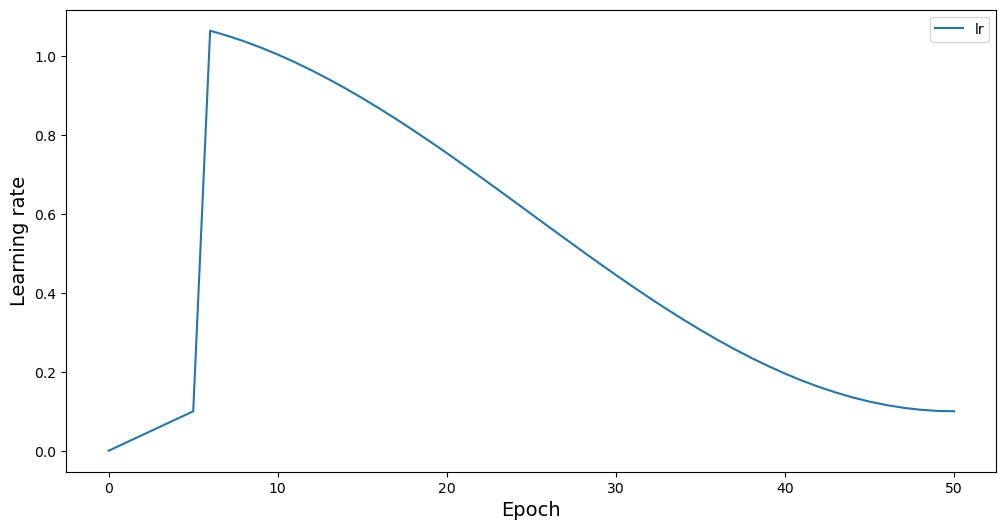

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(list(range(len(lr_list))), lr_list, label = 'lr')
plt.xlabel("Epoch", fontsize = 14)
plt.ylabel("Learning rate", fontsize = 14)
plt.legend()
plt.show()

In [21]:
import os
from ray.tune import CLIReporter
from ray import tune
from torch.utils.data import random_split
from functools import partial

In [45]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr = config["lr"], momentum = 0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size = int(config["batch_size"]),
        shuffle = True,
        num_workers = 0)
    
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size = int(config["batch_size"]),
        shuffle = True,
        num_workers = 0)

    for epoch in range(5):  
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / epoch_steps))
                running_loss = 0.0

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            print("*" * 10, path, "*" * 10)

        tune.report(loss = (val_loss / val_steps), accuracy = correct / total)
    print("Finished Training")

In [45]:
def main(num_samples = 8, gpus_per_trial = 2):
    
    data_dir = os.path.abspath("./data")
    
    config = {
        "l1": tune.grid_search([32, 64]),
        "l2": tune.grid_search([16, 32]),
        "lr": tune.grid_search([1e-4, 1e-2]),
        "batch_size": tune.grid_search([16])
    }
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial = {"cpu": 2, "gpu": gpus_per_trial},
        config = config,
        num_samples = num_samples,
        progress_reporter = reporter
    )

main(num_samples = 8, gpus_per_trial = 1)

2025-12-10 23:07:32,655	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-12-10 23:07:33 (running for 00:00:00.44)
Using FIFO scheduling algorithm.
Logical resource usage: 0/16 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: C:/Users/DELL55~1/AppData/Local/Temp/ray/session_2025-12-10_22-45-43_547543_20124/artifacts/2025-12-10_23-07-32/train_cifar_2025-12-10_23-07-32/driver_artifacts
Number of trials: 64/64 (64 PENDING)


== Status ==
Current time: 2025-12-10 23:07:38 (running for 00:00:05.46)
Using FIFO scheduling algorithm.
Logical resource usage: 0/16 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: C:/Users/DELL55~1/AppData/Local/Temp/ray/session_2025-12-10_22-45-43_547543_20124/artifacts/2025-12-10_23-07-32/train_cifar_2025-12-10_23-07-32/driver_artifacts
Number of trials: 64/64 (64 PENDING)




2025-12-10 23:07:41,700	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-12-10 23:07:41,741	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Dell 5520/ray_results/train_cifar_2025-12-10_23-07-32' in 0.0408s.


== Status ==
Current time: 2025-12-10 23:07:41 (running for 00:00:09.07)
Using FIFO scheduling algorithm.
Logical resource usage: 0/16 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: C:/Users/DELL55~1/AppData/Local/Temp/ray/session_2025-12-10_22-45-43_547543_20124/artifacts/2025-12-10_23-07-32/train_cifar_2025-12-10_23-07-32/driver_artifacts
Number of trials: 64/64 (64 PENDING)
+-------------------------+----------+-------+--------------+------+------+--------+
| Trial name              | status   | loc   |   batch_size |   l1 |   l2 |     lr |
|-------------------------+----------+-------+--------------+------+------+--------|
| train_cifar_55c32_00000 | PENDING  |       |           16 |   32 |   16 | 0.0001 |
| train_cifar_55c32_00001 | PENDING  |       |           16 |   64 |   16 | 0.0001 |
| train_cifar_55c32_00002 | PENDING  |       |           16 |   32 |   32 | 0.0001 |
| train_cifar_55c32_00003 | PENDING  |       |           16 |   64 |   32 | 0.0001 |
| train_cif

KeyboardInterrupt: 

KeyboardInterrupt: 

In [30]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

In [39]:
trainset, testset = load_data('./data')
(X, y) = np.asarray(trainset.data[:]), np.asarray(trainset.targets[:])

X = X.reshape((-1, 3, 32, 32))
X = X.astype(np.float32)
y = y.astype(np.int64)

net = NeuralNetClassifier(
    Net,
    max_epochs = 5,
    lr = 0.01,
    iterator_train__shuffle = True,
)

net.fit(X, y)
y_proba = net.predict_proba(X)

Files already downloaded and verified
Files already downloaded and verified
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3318       0.1015        2.3044  3.1464
      2        2.2926       0.1765        2.2561  2.8745
      3        2.1945       0.2008        2.1252  2.8929
      4        2.0703       0.2483        2.0221  3.0015
      5        1.9685       0.2734        2.0017  3.2073


In [50]:
net.set_params(train_split = False, verbose = 0)

params = {
    'lr': [1e-4, 1e-3, 1e-2],
    'module__l1': [32, 64, 128],
    'module__l2': [16, 32, 64],
}
      
gs = GridSearchCV(net, params, cv = 3, scoring = 'accuracy', verbose = 2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  10.9s
[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  10.4s
[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  11.9s
[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  11.9s
[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  13.3s
[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  12.1s
[CV] END ............lr=0.0001, module__l1=32, module__l2=64; total time=  11.9s
[CV] END ............lr=0.0001, module__l1=32, module__l2=64; total time=  12.0s
[CV] END ............lr=0.0001, module__l1=32, module__l2=64; total time=  12.5s
[CV] END ............lr=0.0001, module__l1=64, module__l2=16; total time=  13.1s
[CV] END ............lr=0.0001, module__l1=64, module__l2=16; total time=  12.8s
[CV] END ............lr=0.0001, module__l1=64, m